In [ ]:
!dir /b /w .

In [1]:
import sys
import os
import torch
sys.path.append(os.path.abspath('../python'))

cuda = torch.cuda.is_available()
dtype = torch.float
from PIL import Image
from imageProcess import toTorch, readFile, toOutput, BGR2RGBTorch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
show = lambda im: Image.fromarray(toOutput(8)(im).transpose(1, 2, 0))
readFile = readFile()

No module named 'pynvml'


In [ ]:
w = torch.load('./model_epoch_200.pth', map_location='cpu')['model'].state_dict()
for name in w.keys():
    print(name)

In [4]:
w = torch.load('./model_epoch_200.pth', map_location='cpu')['model'].state_dict()
w1 = model.state_dict()
for k in w:
    w1[k.replace('module.', '')] = w[k]

In [5]:
from sun_demoire import Net
model = Net()
model.load_state_dict(w1)
model.eval()
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
from sun_demoire_1 import Net
model = Net()
model.eval()
for param in model.parameters():
    param.requires_grad_(False)
weights = model.state_dict()
for name in weights.keys():
    print(name)

In [ ]:
for k in ['relu', 'convt_R1', 'down']:
    for i in range(5):
        weights['downs.{}.{}.weight'.format(i, k)] = w['module.down{}.{}.weight'.format(i, k)]
weights['branches.0.0.weight'] = w['module.branch1.conv_input.weight']
weights['branches.0.1.weight'] = w['module.branch1.relu.weight']
for i in range(1, 5):
    for j in range(i):
        weights['branches.{}.{}.weight'.format(i, j * 2)] = w['module.branch{}.u{}.weight'.format(i + 1, j + 1)]
        weights['branches.{}.{}.bias'.format(i, j * 2)] = w['module.branch{}.u{}.bias'.format(i + 1, j + 1)]
        weights['branches.{}.{}.weight'.format(i, j * 2 + 1)] = w['module.branch{}.relu{}.weight'.format(i + 1, (j + 1) if i > 1 else '')]
    weights['branches.{}.{}.weight'.format(i, i * 2)] = w['module.branch{}.conv.weight'.format(i + 1)]

In [ ]:
keys = ['branches.0.1.weight', 'branches.0.0.weight'] + ['downs.{}.{}.weight'.format(i, k) for i in range(5) for k in ['relu', 'convt_R1', 'down']]
for i in range(1, 5):
    for j in range(i):
        keys.append('branches.{}.{}.weight'.format(i, j * 2))
        keys.append('branches.{}.{}.bias'.format(i, j * 2))
        keys.append('branches.{}.{}.weight'.format(i, j * 2 + 1))
    keys.append('branches.{}.{}.weight'.format(i, i * 2))
for k in weights.keys():
    assert k in keys

In [ ]:
model.load_state_dict(weights)

In [22]:
torch.save(model.state_dict(), '../model/demoire/sun_epoch_200.pth')

In [ ]:
w = o['model'].state_dict()
for name in w.keys():
    print(name)

In [ ]:
for name in weights.keys():
    weights[name] = w['module.' + name]

In [ ]:
def changeName(old, new):
    weights[new] = weights[old]
    del weights[old]

names = ['conv_1.weight', 'conv_2.weight', 'relu.weight', 'scale.scale']
for i in range(6):
    for name in names:
        changeName('convt_F1{}.{}'.format(i + 1, name), 'convt_F{}.{}'.format(i + 1, name))
changeName('convt_shape1.weight', 'u.weight')

In [ ]:
model.load_state_dict(weights)
torch.save(model.state_dict(), '../model/lite/model_4.pth')

In [6]:
fileName = '1566005911.7879605_mi.png'
original = toTorch(8, dtype, device)(readFile(fileName))
if cuda:
    original = original.cuda()
x = original.unsqueeze(0)

In [7]:
if cuda:
    model = model.cuda()

In [ ]:
o = torch.stack([original[2], original[1], original[0]])

In [8]:
out = model(x)[0]

In [9]:
out.shape

torch.Size([3, 1024, 1024])

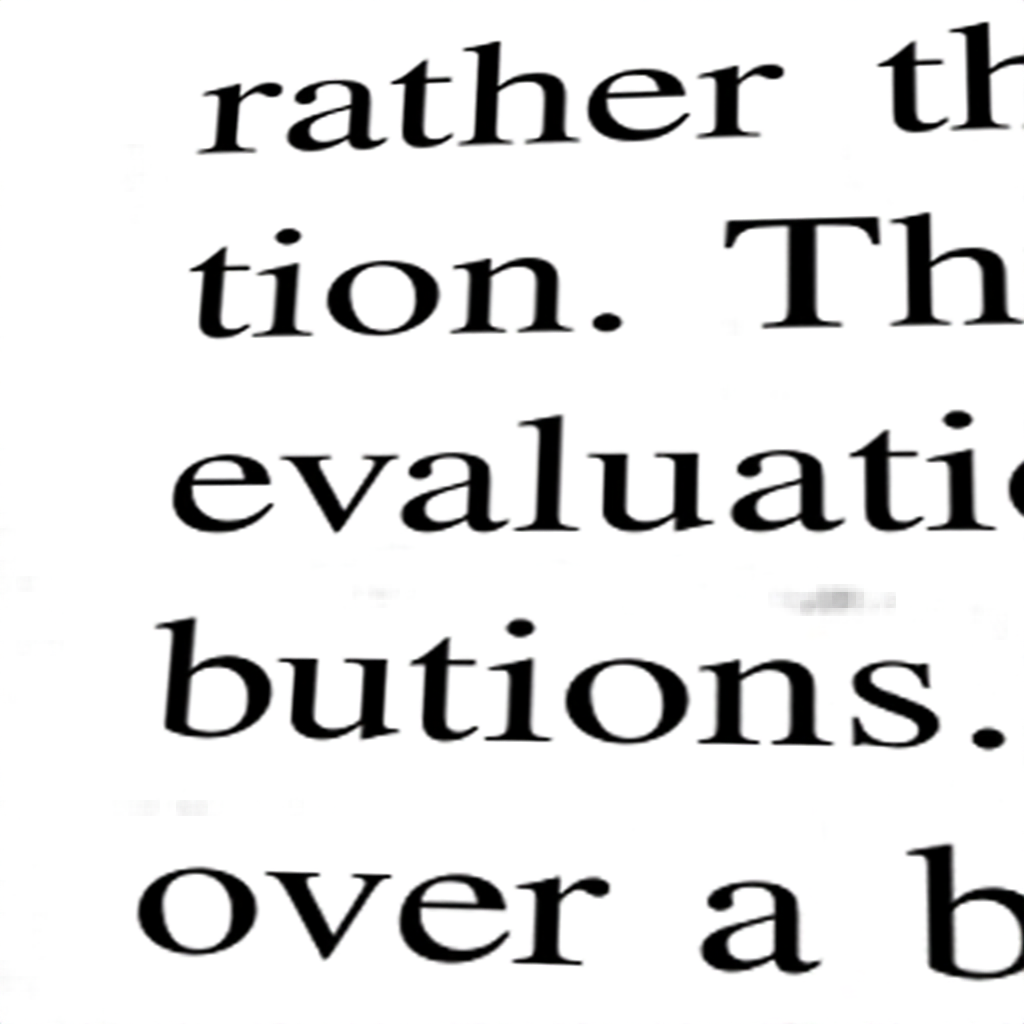

In [10]:
im = show(out.squeeze(0))
im

In [42]:
im.save('out.png')

In [ ]:
from torch import nn
import torch.onnx
torch.onnx.export(model, x, 'lite4.onnx', export_params=True, opset_version=10, do_constant_folding=True,
                  input_names=['x'], output_names=['out'],
                 dynamic_axes={'x': {0: 'channels', 2: 'height', 3: 'weight'}, 'out': {0: 'channels', 2: 'height', 3: 'weight'}})

In [ ]:
import onnx

onnx_model = onnx.load("lite4.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("lite4.onnx")
ort_inputs = {'x': x.cpu().numpy()}

In [ ]:
ort_out = ort_session.run(None, ort_inputs)[0].squeeze(1)

In [ ]:
import numpy as np
np.testing.assert_allclose(out.numpy(), ort_out, rtol=1e-03, atol=1e-05)

In [ ]:
show(torch.from_numpy(ort_out))

In [ ]:
show(out)